In [1]:
import os, datetime
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib as mpl
from sklearn import preprocessing

mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams['figure.dpi']= 300
TITLESIZE = 24
LEGENDSIZE = 15
TICKSIZE = 15
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
def make_prediction(model, X, U, window_size, horizon):
    forecast_all = X[0:window_size, deco_sel].numpy()
    for i in range(window_size, X.shape[0], horizon):
        past = X[:i, enco_sel]
        if i + horizon <= X.shape[0]:
            x_temp = past[i - window_size:i, :].reshape(1, -1).float()
            u_temp = U[i-window_size:i + horizon, :].reshape(1, -1).float()
            _, _, _, pred_next, _ = model(x_temp, u_temp)
            pred_next = pred_next[:, 0:DECO_DIM * horizon].reshape(horizon, DECO_DIM)
            forecast_all = np.vstack((forecast_all, pred_next.data.numpy()))
    return forecast_all

def plotwithtime(ind,time,x,xpred,time_og, u):
    varname = np.array(variable_name)[deco_sel[plot_sel]]
    nrows = 3
    ncols = 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 8, nrows * 5))
    axesf = axes.flatten()
    plt.subplots_adjust(hspace=0.3,wspace = 0.1)
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    days = mdates.DayLocator()  # every month
    for i in range(ncols * nrows):
        ax1 = axesf[i]
        if i < 8:
            discon = np.where(np.diff(ind) != 1)[0].reshape(-1, ) + 1
            if discon.shape[0] == 0:
                ax1.plot(time, x[:, i], linestyle='-',linewidth = 1,c = 'k')
                ax1.plot(time, xpred[:,i], linestyle='-',linewidth = 1, c = 'royalblue')
            else:
                ax1.plot(time[:discon[0]], x[:discon[0], i], linestyle='-',linewidth = 1.4,c = 'orange', alpha = 1)
                ax1.plot(time[:discon[0]], xpred[:discon[0],i], linestyle='-',linewidth = 1, c = 'royalblue', alpha = 1)
                for j in range(np.shape(discon)[0]):
                    if j == np.shape(discon)[0] - 1: # At the end
                        ax1.plot(time[discon[j]:xpred.shape[0]], 
                                 x[discon[j]:xpred.shape[0], i], linestyle='-',linewidth = 1.4,c = 'orange', alpha = 1)
                        ax1.plot(time[discon[j]:xpred.shape[0]], 
                                 xpred[discon[j]:xpred.shape[0],i], linestyle='-',linewidth = 1, c = 'royalblue', alpha = 1)
                    else:
                        ax1.plot(time[discon[j]:discon[j+1]], x[discon[j]:discon[j+1], i], linestyle='-',linewidth = 1.4,c = 'orange', alpha = 1)
                        ax1.plot(time[discon[j]:discon[j]+xpred[discon[j]:discon[j+1],:].shape[0]], xpred[discon[j]:discon[j+1],i], linestyle='-',linewidth = 1, c = 'royalblue', alpha = 1)
            for j in range(len(discon)):
                for k in np.arange(time[discon[j]-1], time[discon[j]]):
                    ax1.axvline(k, color = 'silver',  linewidth = 3, linestyle='-.',alpha = 0.2)
            ax1.set_title(varname[i] ,fontsize = TITLESIZE)
            ax1.set_xlim(time[0],time[-1])
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
            ax1.xaxis.set_minor_locator(months)
            ax1.tick_params(axis='both', which='major', labelsize=TICKSIZE)
        elif i >= 8 & i-8 < u.shape[1]:            
            ax1 = axesf[i]
            discon = np.where(np.diff(ind) != 1)[0].reshape(-1, ) + 1
            if discon.shape[0] == 0:
                ax1.plot(time, u[:, i-DECO_DIM], linestyle='-',linewidth = 1,c = 'k',alpha = 1)        
            else:
                ax1.plot(time[:discon[0]], u[:discon[0], i-8], linestyle='-',linewidth = 0.8,c = 'k',alpha = 1)
                for j in range(np.shape(discon)[0]):
                    if j == np.shape(discon)[0] - 1: # At the end
                        ax1.plot(time[discon[j]:xpred.shape[0]], 
                                 u[discon[j]:xpred.shape[0], i-8], linestyle='-',linewidth = 1,c = 'k',alpha = 1)
                    else:
                        ax1.plot(time[discon[j]:discon[j+1]], u[discon[j]:discon[j+1], i-8], linestyle='-',linewidth = 1,c = 'k',alpha = 1)
            for j in range(len(discon)):
                for k in np.arange(time[discon[j]-1], time[discon[j]]):
                    ax1.axvline(k, color = 'silver',  linewidth = 3, linestyle='-.',alpha = 0.2)
            ax1.set_title(control_name[i-8],fontsize = TITLESIZE)
            ax1.set_xlim(time[0],time[-1])
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
            ax1.xaxis.set_minor_locator(months)
            ax1.tick_params(axis='both', which='major', labelsize=TICKSIZE)
            line1, = ax1.plot(np.arange(-10,0), u[0:10,i-8], c = 'orange', linewidth = 5, alpha = 0.8)
            line2, = ax1.plot(np.arange(-10,0), u[0:10,i-8], c = 'royalblue', linewidth = 5, alpha = 0.8)
            line3 = ax1.axvline(time[0] - 10, color = 'silver',  linewidth = 5, linestyle='-.',alpha = 0.8)
            line4, = ax1.plot(np.arange(-10, 0), u[0:10,i-8], linestyle='-',linewidth = 5,c = 'k',alpha = 0.8)
        else:
            ax1.axis('off')
    fig.legend([line1, line2, line3, line4], ['Measurement', 'Prediction', 'Unit Shutdown', 'Exogenous Variables'], 
           bbox_to_anchor=(0.74, 0.1), ncol=4, prop={'size': TITLESIZE})     

#### Load Fault Free Test Data

In [3]:
df = pd.read_csv('normal_X.csv', sep=',',header=0)
variable_name = df.columns
x_test_normal= df.to_numpy()
df = pd.read_csv('normal_U.csv', sep=',',header=0)
control_name = df.columns
u_test_normal= df.to_numpy()
df = pd.read_csv('normal_Operation_Ind.csv', sep=',',header=0)
normal_operation_ind = df.to_numpy().reshape(-1)
df = pd.read_csv('normal_ALL_Time.csv', sep=',',header=0)
normal_time= df.to_numpy().reshape(-1)

#### Define NN Model

In [4]:
class DNNATTEN(nn.Module):
    def __init__(self, step, nfactor):
        super().__init__()
        self.encoder = nn.Linear(ENCO_DIM, nfactor)
        self.A = nn.Linear(step * nfactor, nfactor, bias = False)
        self.B = nn.Linear(INPUT_DIM, nfactor)
        self.attn = nn.Linear(2*nfactor, step, bias = False)
        self.decoder = nn.Linear(nfactor, DECO_DIM)
    def forward(self, x, u):
        temp = torch.tanh(self.encoder(x.reshape(BATCH_SIZE, WINDOW_SIZE, ENCO_DIM)))
        temp2 = torch.tanh(self.B(u[:, :INPUT_DIM * WINDOW_SIZE].reshape(BATCH_SIZE, WINDOW_SIZE, INPUT_DIM)))
        prev_state = temp - temp2
        for i in range(WINDOW_SIZE, HORIZON + WINDOW_SIZE):
            prev_input = self.B(u[:, (i-1) * INPUT_DIM:(i) * INPUT_DIM])
            current_input = self.B(u[:, i * INPUT_DIM:(i + 1) * INPUT_DIM])
            attn_weights = F.softmax(self.attn(torch.cat((torch.tanh(prev_input), torch.tanh(current_input)),dim = 1)), dim=1)
            temp = prev_state.permute(0,2,1)
            selected_state = torch.bmm(temp, torch.diag_embed(attn_weights)).reshape(BATCH_SIZE, -1)
            latent = self.A(selected_state) + torch.tanh(current_input)
            if i == WINDOW_SIZE:
                all_pred = self.decoder(latent)
                all_x_contri = self.A(selected_state)
                all_u_contri = F.torch.tanh(current_input)
                all_latent = latent
                all_atten = attn_weights
            else:
                all_pred = torch.cat((all_pred, self.decoder(latent)), dim=1)
                all_x_contri = torch.cat((all_x_contri, self.A(selected_state)), dim=1)
                all_u_contri = torch.cat((all_u_contri, torch.tanh(current_input)), dim=1)
                all_latent = torch.cat((all_latent, latent), dim=1)
                all_atten = torch.cat((all_atten, attn_weights), dim=1)
            prev_state = torch.cat((prev_state[:,1:,:], self.A(selected_state).view(BATCH_SIZE,1,NFACTOR)), dim=1)
        return all_x_contri, all_u_contri, all_latent, all_pred, all_atten  

#### Predictions of Test Data

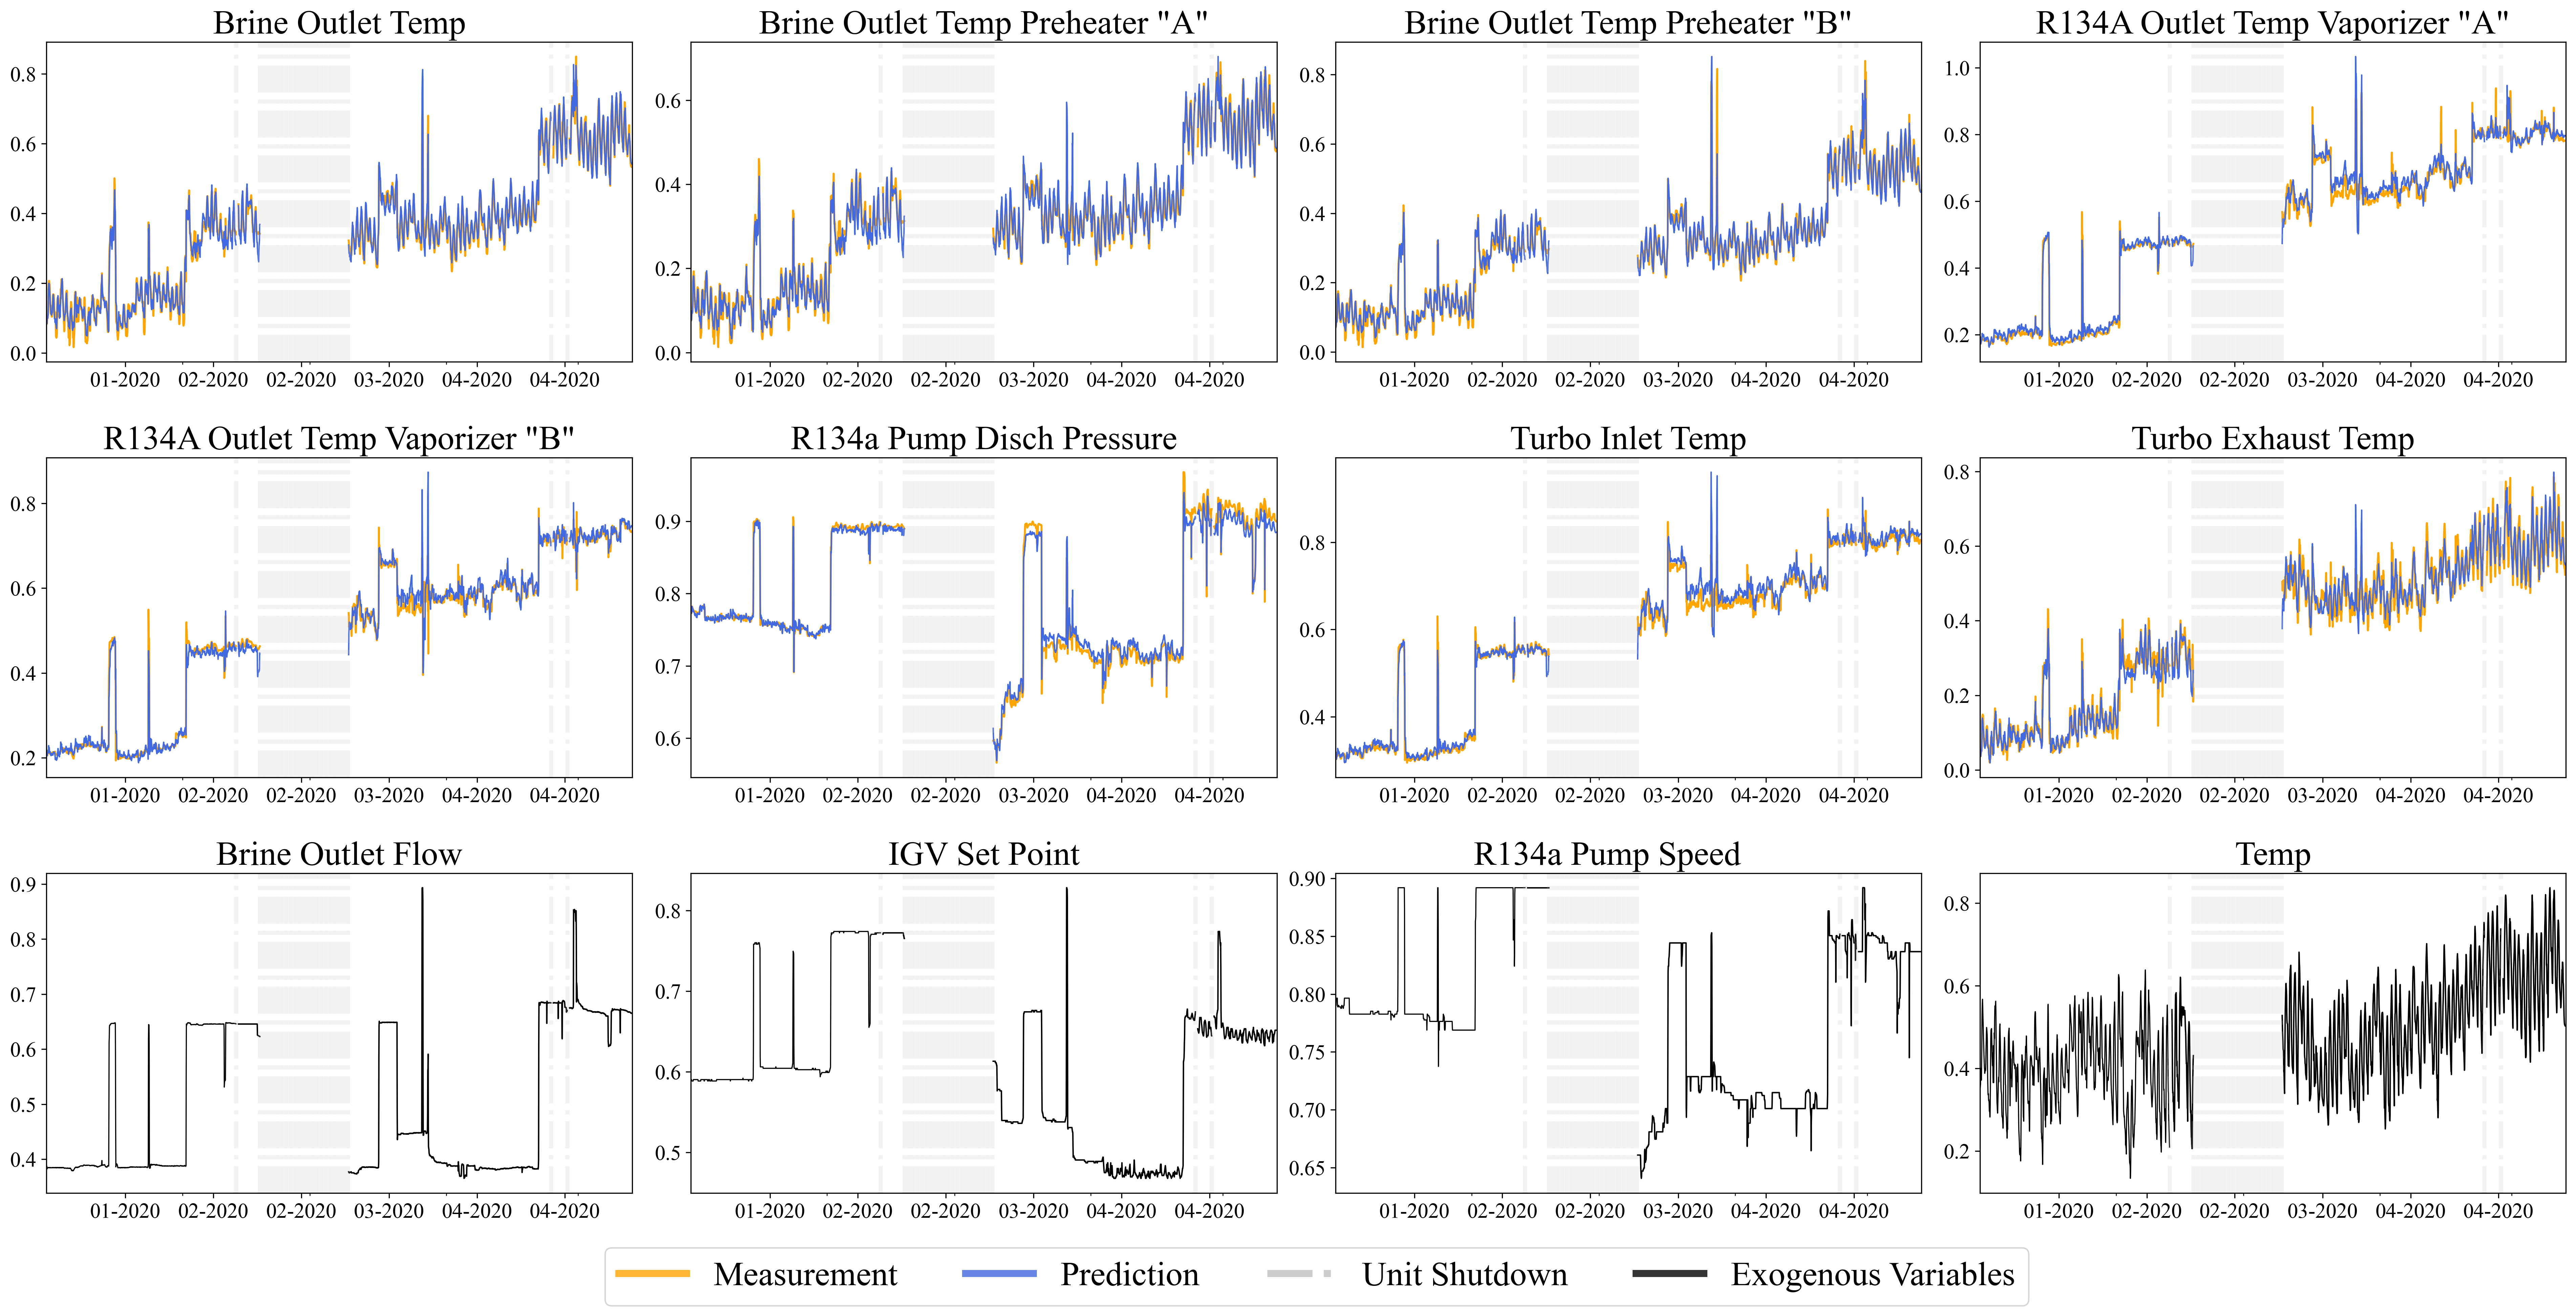

In [5]:
## 15 varaibles
enco_sel = deco_sel = np.array([2,3,4,5,6,7,8,9,10,11,12,14,15,16,17])
INPUT_DIM = 4
ENCO_DIM = np.shape(enco_sel)[0]
DECO_DIM = np.shape(enco_sel)[0]
NFACTOR = 10
WINDOW_SIZE = 12
HORIZON = 12
BATCH_SIZE = 1
x_test_t = torch.from_numpy(x_test_normal)
u_test_t = torch.from_numpy(u_test_normal)

model = DNNATTEN(WINDOW_SIZE,NFACTOR)
model.load_state_dict(torch.load('DNNAtten', map_location=torch.device('cpu')))
model.eval()
pred_result = make_prediction(model,x_test_t,u_test_t,WINDOW_SIZE, HORIZON)

plot_sel = np.array([0,3,4,7,9,10,11,13])
plotwithtime(normal_operation_ind,normal_time[normal_operation_ind],x_test_normal[:,deco_sel[plot_sel]],pred_result[:, plot_sel],normal_time,u_test_normal)

## Fault Detection

#### Load Faulty Data

In [6]:
df = pd.read_csv('fault_X.csv', sep=',',header=0)
x_test_fault= df.to_numpy()
df = pd.read_csv('fault_U.csv', sep=',',header=0)
u_test_fault= df.to_numpy()
df = pd.read_csv('fault_Operation_Ind.csv', sep=',',header=0)
fault_operation_ind = df.to_numpy().reshape(-1)
df = pd.read_csv('fault_ALL_Time.csv', sep=',',header=0)
fault_time = df.to_numpy().reshape(-1)
fault_time = fault_time[fault_operation_ind]

#### Get Residuals for Normal Data and Faulty Data

In [7]:
HORIZON = 1
x_test_fault_t = torch.from_numpy(x_test_fault)
u_test_fault_t = torch.from_numpy(u_test_fault)
## Make 1 step ahead prediction
pred_result = make_prediction(model,x_test_t,u_test_t,WINDOW_SIZE, HORIZON)
pred_result_fault = make_prediction(model,x_test_fault_t,u_test_fault_t,WINDOW_SIZE, HORIZON)
## Calculate residuals
xres_normal = x_test_normal[WINDOW_SIZE:pred_result.shape[0],enco_sel] - pred_result[WINDOW_SIZE:,:]
xres_fault = x_test_fault[WINDOW_SIZE:pred_result_fault.shape[0],enco_sel] - pred_result_fault[WINDOW_SIZE:,:]

#### Build PCA Model from Normal Residuals for Fault Detection

In [8]:
from scipy.stats import chi2
scaler = preprocessing.StandardScaler().fit(xres_normal)
xres_normal_scaled = scaler.transform(xres_normal)
xres_fault_scaled = scaler.transform(xres_fault)

u, s, vh = np.linalg.svd(xres_normal_scaled.T@xres_normal_scaled/(xres_normal_scaled.shape[0] - 1), full_matrices=False)
P = vh.T
npc = 7
P_sel = P[:,:npc]
P_res = P[:,npc:]
## SPE
capphi_spe =P_res @ P_res.T
tr = np.sum(s[npc:])
trsq = np.sum(s[npc:]**2)
g = trsq/tr
h = tr**2/trsq
spelim = g*chi2.ppf(0.99, df=np.round(h))
## T2
lamb = np.diag(s[:npc])
capphi_T2 = P_sel@np.linalg.inv(lamb)@P_sel.T
T2lim = chi2.ppf(0.99, df=npc)
## Combine
capphi_combine=capphi_T2/T2lim + capphi_spe/spelim;
tr=npc/T2lim+tr/spelim;
trsq=npc/T2lim**2+trsq/spelim**2;
g1 = trsq/tr;
h = tr**2/trsq;
comblim = g1*chi2.ppf(0.99, df=np.round(h))

spe_test = []
T2_test = []
comb_test = []
for j in range(0,xres_fault_scaled.shape[0]):
    spe_test.append(xres_fault_scaled[j,:]@capphi_spe@xres_fault_scaled[j,:].T)
    T2_test.append(xres_fault_scaled[j,:]@capphi_T2@xres_fault_scaled[j,:].T)
    comb_test.append(xres_fault_scaled[j,:]@capphi_combine@xres_fault_scaled[j,:].T)

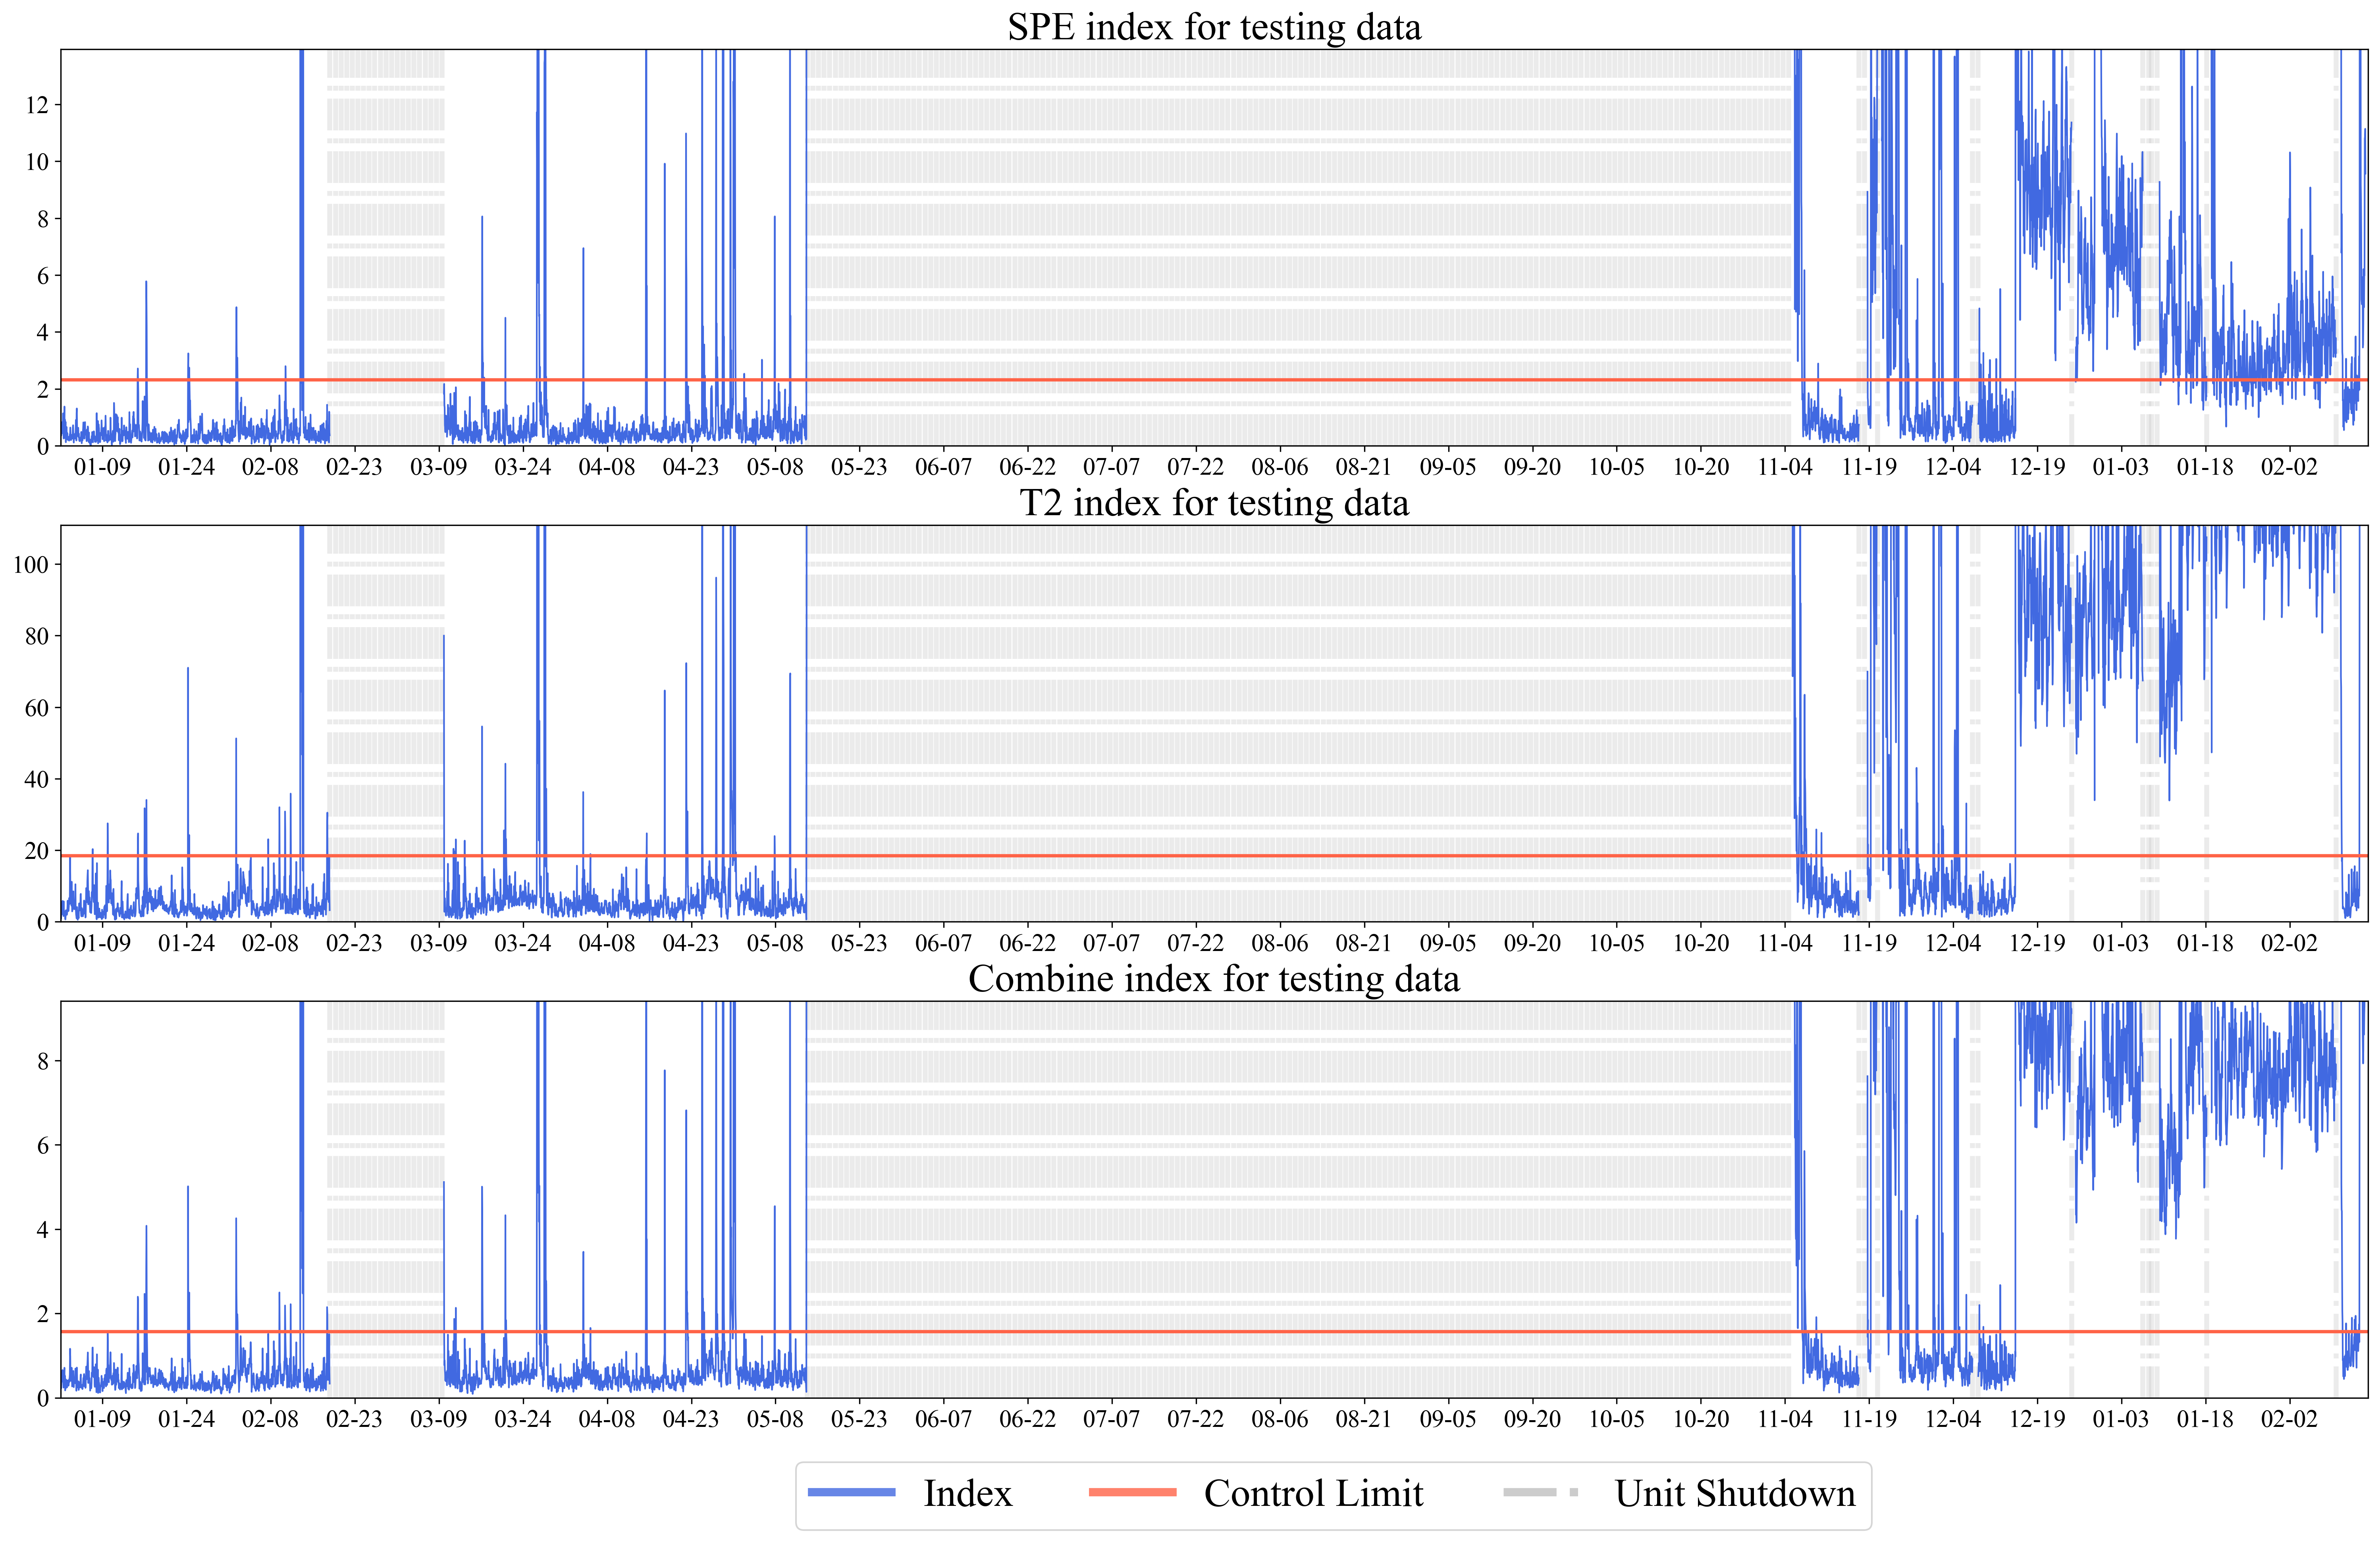

In [9]:
index = ['SPE', 'T2', 'Combine']
fig,axes = plt.subplots(3,1,figsize=(25,15))
ax = axes.flatten()
for i in range(3):
    discon = np.where(np.diff(fault_operation_ind) != 1)[0].reshape(-1, ) + 1
    if index[i] == 'SPE':
        temp = spe_test
        lim = spelim
    elif index[i] == 'T2':
        temp = T2_test
        lim = T2lim
    else:
        temp = comb_test
        lim = comblim
    for j in range(len(discon)):
        for k in np.arange(fault_time[discon[j]-1], fault_time[discon[j]]):
            ax[i].axvline(k, color = 'silver',  linewidth = 3, linestyle='-.',alpha = 0.3)
    if discon.shape[0] == 0:
        ax[i].plot(fault_time[WINDOW_SIZE:], spe_test, linestyle='-',linewidth = 1,color='royalblue')
    else:
        ax[i].plot(fault_time[WINDOW_SIZE:discon[0]], temp[:discon[0]-WINDOW_SIZE], linestyle='-',linewidth = 1,color='royalblue')
        for j in range(np.shape(discon)[0]):
            if j == np.shape(discon)[0] - 1: # At the end
                ax[i].plot(fault_time[discon[j]:np.shape(temp)[0]], 
                         temp[discon[j]-WINDOW_SIZE:np.shape(temp)[0]-WINDOW_SIZE], linestyle='-',linewidth = 1,color='royalblue',label='Index')
            else:
                ax[i].plot(fault_time[discon[j]:discon[j+1]], temp[discon[j]-WINDOW_SIZE:discon[j+1]-WINDOW_SIZE], linestyle='-',linewidth = 1,color='royalblue')       
    ax[i].hlines(lim, fault_time[WINDOW_SIZE], fault_time[-1], colors='tomato', linestyles='solid',label='Control limit', linewidth = 2)
    ax[i].tick_params(axis='x', labelrotation= 0 )
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    days = mdates.DayLocator()  # every month
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(30))
    ax[i].set_xlim(fault_time[WINDOW_SIZE],fault_time[-1])
    ax[i].set_ylim(0,lim*6)
    ymin,ymax = ax[i].get_ylim()
    ax[i].set_title(index[i] + ' index for testing data', size=TITLESIZE)
    ax[i].tick_params(axis='both', which='major', labelsize=TICKSIZE)
    
line1, = ax[2].plot(np.arange(-10,0), comb_test[0:10], c = 'royalblue', linewidth = 5, alpha = 0.8)
line2, = ax[2].plot(np.arange(-10,0), comblim*np.ones(10), c = 'tomato', linewidth = 5, alpha = 0.8)
line3 = ax[2].axvline(fault_time[0] - 10, color = 'silver',  linewidth = 5, linestyle='-.',alpha = 0.8)
fig.legend([line1, line2, line3], ['Index', 'Control Limit', 'Unit Shutdown'], 
           bbox_to_anchor=(0.74, 0.1), ncol=4, prop={'size': TITLESIZE})     